In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import bokeh.io
import bokeh.plotting
from bokeh.palettes import Spectral11
from scipy.signal import butter, lfilter, freqz, find_peaks, correlate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
#from Butterworth_Filter import butter_bandpass, butter_bandpass_filter
import glob
from quantities import ms, s, Hz
#from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
import math
from collections import Counter
import scipy

from time import strftime
%matplotlib inline



In [167]:
# helper line -> get different outpaths for sorted datasets; uncheck the date

#191021
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting'
# outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'



#191021extra
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021extra'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_29042021_hCSF_child_20min_spont_spikesorting'


#191017
mainpath = 'D:\Files_Reutlingen_Jenny\main_191017'
outpath = 'D:\Files_Reutlingen_Jenny\main_191017\_output_Spikesorting_30042021_spontaneous_spikesorting'



#191023
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191023'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_hCSF_afterDNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_spikesorting'


#15052021 Aachen
#mainpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4'
#outpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4\_output_Spikesorting_07062021_cortex_div4_hCSF_ID039_nodrug_spont_1_spikesorting'

labeldic =  np.load(
    'D:\Files_Reutlingen_Jenny\_layerdictionaries\labeldictionary_MCS_256MEA.npy', 
    allow_pickle='TRUE').item() 

In [168]:
os.chdir(mainpath)
folderlist = glob.glob('*_output_Spikesorting*spikesorting*')

In [81]:
os.chdir(r'D:\MEA_DATA_Aachen\ANALYZED\2021-05-17_cortex_div11_hCSF_ID046_nodrug_spont_2_analyzed_on_04082021')

In [70]:
# loading functions

def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic


# function to get the filebase from folder
def get_filebase_from_foldername(mainpath_folder):
    
    separator = '_'
    filebase = separator.join(mainpath_folder.split('\\')[-1].split('_')[4:-1])
    
    return filebase




def get_dictionary_keys(outpath_folder):

    dictkeys = []
    os.chdir(outpath_folder)
    folders_sorting = glob.glob('*sorted*')
    for i in folders_sorting:
        dk = i.split('sorted_')[1]
        dictkeys.append(dk)
    
    return dictkeys, print('Dictkeys are %s. Your CWD may have changed. Please check.' %dictkeys)



# function to convert basic information to dataframe
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
        
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
       
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
        
    return unitframe




def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert
    

In [71]:
# get a filebaselist for every folder in the mainpath, that we we can filter 

filebase_list = []
for i in folderlist:
    filebase = get_filebase_from_foldername(i)
    filebase_list.append(filebase)

NameError: name 'folderlist' is not defined

In [72]:
filebase_list

[]

In [172]:
filebase = filebase_list[1]

In [173]:
os.chdir(outpath)

In [174]:
#cfc = pd.read_pickle(str('DF_' + filebase + '_' + 'complete_with_cluster') + '_df.pkl')

In [175]:
completeframe = pd.read_pickle('DF_' + filebase + '_' + 'complete' + '_df.pkl')

In [176]:
completeframe

,unit_ids,unit_index,max_channel,channellabel,n_spikes,firing_rate,layer,ft_peak_to_valley,ft_halfwidth,ft_peak_trough_ratio,ft_repolarization_slope,ft_recovery_slope,qm_firing_rate,qm_isi_violation,qm_amplitude_cutoff,qm_presence_ratio,qm_snr,file,subrecording,recordingdate
0,0,0.0,0.0,R12,123.0,1.025000,layer4,0.00028,0.00016,-0.221239,0.087499,-0.002170,1.025000,0.000000,0.002104,0.74,3.815127,spontaneous,sec_0-120,17.10.2019
1,1,1.0,10.0,R4,219.0,1.825001,layer2-3,0.00064,0.00020,-0.116071,0.034418,-0.002202,1.825001,2.535843,0.001182,0.90,4.106966,spontaneous,sec_0-120,17.10.2019
2,10,2.0,182.0,F11,21.0,0.175000,layer5-6,0.00060,0.00028,-0.106383,0.043039,-0.010927,0.175000,0.000000,0.012323,0.07,6.900513,spontaneous,sec_0-120,17.10.2019
3,100,3.0,206.0,D12,154.0,1.283334,layer5-6,0.00104,0.00032,-0.153846,0.024931,-0.002087,1.283334,1.709417,0.414959,0.28,4.733220,spontaneous,sec_0-120,17.10.2019
4,101,4.0,206.0,D12,22.0,0.183333,layer5-6,0.00128,0.00044,-0.287500,0.034263,-0.002030,0.183333,0.000000,0.012002,0.08,7.281877,spontaneous,sec_0-120,17.10.2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,95,204.0,176.0,F14,47.0,0.391667,layer5-6,0.00076,0.00040,-0.521739,0.057508,-0.008802,0.391667,0.000000,0.011265,0.24,6.130469,spontaneous,sec_0-120,17.10.2019
205,96,205.0,176.0,F14,295.0,2.458334,layer5-6,0.00076,0.00028,-0.380952,0.031936,-0.004627,2.458334,0.465849,0.100591,0.71,4.198039,spontaneous,sec_0-120,17.10.2019
206,97,206.0,196.0,C5,155.0,1.291667,layer2-3,0.00088,0.00016,-0.135135,0.056547,-0.003849,1.291667,1.687431,0.001670,0.82,4.062950,spontaneous,sec_0-120,17.10.2019
207,98,207.0,206.0,D12,51.0,0.425000,layer5-6,0.00064,0.00024,-0.365517,0.129556,-0.011700,0.425000,15.586516,0.231702,0.11,10.558721,spontaneous,sec_0-120,17.10.2019


In [4]:
import plotly.graph_objects as go

import networkx as nx


In [82]:
burst_connections_dic = np.load('cortex_div11_hCSF_ID046_nodrug_spont_2_burst_connections_dic.npy', allow_pickle=True).item()

In [83]:
burst_connections_dic

{'G13': [],
 'G12': [],
 'F16': [],
 'F15': [('J14', 1, 0.011399999999999999),
  ('H15', 1, 0.02332),
  ('H13', 1, 0.012039999999999999),
  ('H14', 2, 0.08188),
  ('G14', 2, 0.13535999999999998)],
 'F14': [],
 'F13': [],
 'F12': [],
 'E16': [],
 'E15': [],
 'E14': [],
 'E13': [],
 'G11': [],
 'D16': [],
 'D15': [],
 'D14': [],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [],
 'B14': [],
 'G10': [],
 'E12': [],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [],
 'C10': [],
 'D10': [],
 'A10': [],
 'B10': [],
 'D9': [],
 'E9': [],
 'B9': [],
 'C9': [],
 'F9': [],
 'A9': [],
 'G8': [],
 'G9': [],
 'A8': [],
 'F8': [],
 'C8': [],
 'B8': [],
 'E8': [],
 'D8': [],
 'B7': [],
 'A7': [],
 'D7': [],
 'C7': [],
 'A6': [],
 'E7': [],
 'C6': [],
 'B6': [],
 'E6': [],
 'D6': [],
 'B5': [],
 'A5': [],
 'D5': [],
 'C

In [84]:
simple_burst_connection = {}

for key in burst_connections_dic:
    listed_connections = []
    for i in burst_connections_dic[key]:
        if i[1] > 0: # anzahl der geshareten bursts
        #if i[2] > 3: # Länge der gesharedten bursts in sec
        #if (i[1] > 10) & (i[2] > 1): # Länge der gesharedten bursts in sec
            listed_connections.append(i[0])
    simple_burst_connection[key] = listed_connections

In [8]:
#simple_burst_connection

In [73]:
# Reutlingen
all_channels = ['D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                        'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                        'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'I3', 'K3', 'K4', 
                         'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                         'P12', 'P13', 'P14', 'P15', 'P16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                         'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                         'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                         'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                         'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'I4', 
                         'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'K5', 'K6', 
                         'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                         'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                         'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                         'O14', 'O15', 'O16', 'A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16']

In [74]:
all_channels = ['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3',
                        'N4', 'N5', 'N6', 'N7','N8', 'N9', 'N10', 'N11', 'N12',
                        'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 
                        'O13', 'O14', 'O15', 'O16', 'P1', 'P2', 'P3', 'P4', 
                        'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 
                        'P13', 'P14', 'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15', 'K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 
                     'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14',
                     'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 
                     'M11', 'M12', 'M13', 'M14', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 
                       'K12', 'K13', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 
                       'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 
                       'J16', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 
                       'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 
                      'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                      'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
                      'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 
                       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 
                       'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 
                          'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 
                          'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 
                          'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]

In [220]:
# layerdic 21.10.2019 Reutlinge

layerdic = {'layer1':[], 
            'layer2-3':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                        'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P1', 
                        'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'I1', 'I2', 'I3', 'I4', 
                       'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H1', 'H2', 'H3', 
                       'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [21]:
# layerdic 17.10.2019
layerdic = {'layer1':['B1', 'C1', 'D1', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'H2', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'M1', 'M2', 'N1', 'N2', 'O1', 'O2', 'P1', 'P2', 'R2'], 
            'layer2-3': ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B2', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'I3', 'I4', 
                          'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'K3', 'K4', 'K5', 'K6', 
                          'K7', 'K8', 'K9', 'K10', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 
                          'L10',  'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'O3', 'O4', 'O5', 'O6', 
                       'O7', 'O8', 'O9', 'O10', 'O11', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'R3', 'R4', 'R5', 
                         'R6', 'R7', 'R8', 'R9', 'R10', 'R11'],
           'layer4':    ['A8', 'A9', 'B9', 'C9', 'C10', 'D9', 'D10', 'E10', 'F10', 'G10', 'H10', 'H11', 'I11', 'K11', 'L11', 'M11', 'M12', 'N11', 'N12', 'O12', 'P12', 'P13', 'R12', 'R13'],
           'layer5-6':  ['A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'D11', 'D12', 
                         'D13', 'D14', 'D15', 'D16',  'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',  'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'H12', 'H13', 'H14', 'H15', 'H16', 'I12', 'I13', 'I14', 'I15', 'I16', 'K12', 'K13', 'K14', 'K15', 'K16', 'L12', 'L13', 'L14', 'L15', 'L16', 'M13', 
                         'M14', 'M15', 'M16', 'N13', 'N14', 'N15', 'N16', 'O13', 
                         'O14', 'O15', 'O16', 'P14', 'P15', 'P16', 'R14', 'R15'],
           'whitematter':[]}

In [75]:
# if layers are not known yet
layerdic = {'na':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3',
                        'N4', 'N5', 'N6', 'N7','N8', 'N9', 'N10', 'N11', 'N12',
                        'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 
                        'O13', 'O14', 'O15', 'O16', 'P1', 'P2', 'P3', 'P4', 
                        'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 
                        'P13', 'P14', 'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15', 'K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 
                     'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14',
                     'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 
                     'M11', 'M12', 'M13', 'M14', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 
                       'K12', 'K13', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 
                       'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 
                       'J16', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 
                       'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 
                      'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                      'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
                      'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 
                       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 
                       'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 
                          'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 
                          'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 
                          'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [85]:
inverted_layerdic = invert_layerdic(layerdic)

In [247]:
layer_colors={'layer1':'#F28749', 'layer2-3':'#B5D932', 'layer4':'#8C3A67', 'layer5-6':'#3F93A6', 'whitematter':'#C9F2EE'}

In [86]:
# this block creates coordinates as on a MEA Grid for each channel
# coordinates are between 0 and 1 via np.linspace

# CAVE: I needs to be exchanged for J for Aachen Data, or i.e. the not MC Rack obtained data
columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
mea_coordinates = np.linspace(0,1,16)
mea_positional_coordinates_dic = {}

for i in all_channels:
    x_num = columnlist.index(i[0])
    x_coord = mea_coordinates[x_num]
    y_num = 17-int(i[1:]) # minus 1 since python starts counting at zero
    y_coord = 1-(mea_coordinates[-y_num])
    mea_positional_coordinates_dic[i] = [x_coord, y_coord]

In [249]:
#mea_positional_coordinates_dic

In [88]:
burst_conn_graph = nx.Graph()

In [89]:
for key in simple_burst_connection:
    for i in simple_burst_connection[key]:
        burst_conn_graph.add_edge(key, i)

In [90]:
burst_conn_graph.number_of_nodes()

6

In [91]:
burst_conn_graph.number_of_edges()

9

In [92]:
G = burst_conn_graph

In [93]:
G.nodes

NodeView(('F15', 'J14', 'H15', 'H13', 'H14', 'G14'))

In [94]:
for i in G.nodes():
    node_key = i
    coordinate = mea_positional_coordinates_dic[node_key]
    G.nodes[node_key]['pos']=coordinate
    #G.nodes[node_key]['layer']=inverted_layerdic[i]
    #G.nodes[node_key]['color']=layer_colors[inverted_layerdic[i]]
    G.nodes[node_key]['degree_centrality']=nx.degree_centrality(G)[i]
    #print(i)


In [95]:
pos = nx.get_node_attributes(G, 'pos')

In [96]:
layers = nx.get_node_attributes(G, 'layer')

In [282]:
colors = nx.get_node_attributes(G, 'color').values()

In [98]:
G.nodes['F15']

{'pos': [0.3333333333333333, 0.06666666666666665], 'degree_centrality': 1.0}

In [99]:
G.nodes['L1']

KeyError: 'L1'

In [100]:
G.nodes['L2']

KeyError: 'L2'

In [101]:
nx.degree_centrality(G)

{'F15': 1.0,
 'J14': 0.4,
 'H15': 0.6000000000000001,
 'H13': 0.2,
 'H14': 0.6000000000000001,
 'G14': 0.8}

In [63]:
layer_colors

NameError: name 'layer_colors' is not defined

In [102]:
nx.degree_centrality(G)

{'F15': 1.0,
 'J14': 0.4,
 'H15': 0.6000000000000001,
 'H13': 0.2,
 'H14': 0.6000000000000001,
 'G14': 0.8}

In [103]:
[G.nodes[v]['degree_centrality'] for v in G]

[1.0, 0.4, 0.6000000000000001, 0.2, 0.6000000000000001, 0.8]

In [104]:
import matplotlib.patches as mpatches

NameError: name 'colors' is not defined

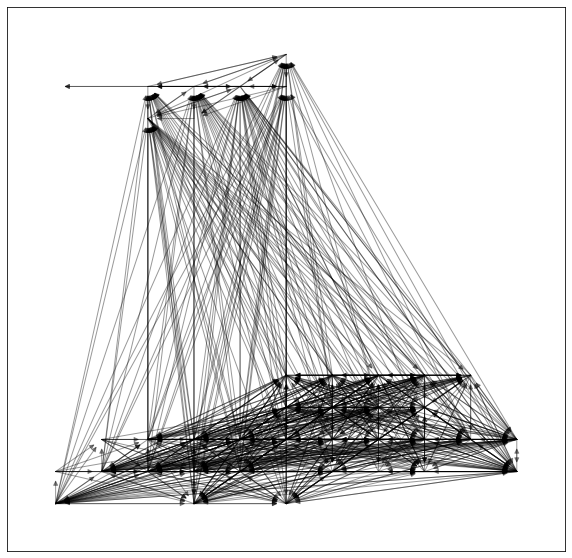

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,10))


nx.draw_networkx_edges(
    G,
    pos, 
    alpha=0.4, 
    edge_color='#000000',
    ax=ax,
)
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=120,
    node_color=colors,
    cmap='viridis',
    ax=ax
)


ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
#ax.set_xticks(columnlist)
ax.grid(ls=':')
#plt.axis("off")
#ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
layer1 = mpatches.Patch(color='#F28749', label='layer 1')
layer23 = mpatches.Patch(color='#B5D932', label='layer 2/3')
layer4 = mpatches.Patch(color='#8C3A67', label='layer 4')
layer56 = mpatches.Patch(color='#3F93A6', label='layer 5/6')
wm = mpatches.Patch(color='#C9F2EE', label='whitematter')
plt.legend(handles=[layer1, layer23, layer4, layer56, wm])


plt.show()

fig.savefig('pseudo_anatomy_burst_graph_'+filebase+'_.png', dpi = 300, transparent=True)

(-0.05, 1.05)

(-0.05, 1.05)

"\nlayer1 = mpatches.Patch(color='#F28749', label='layer 1')\nlayer23 = mpatches.Patch(color='#B5D932', label='layer 2/3')\nlayer4 = mpatches.Patch(color='#8C3A67', label='layer 4')\nlayer56 = mpatches.Patch(color='#3F93A6', label='layer 5/6')\nwm = mpatches.Patch(color='#C9F2EE', label='whitematter')\nplt.legend(handles=[layer1, layer23, layer4, layer56, wm])\n"

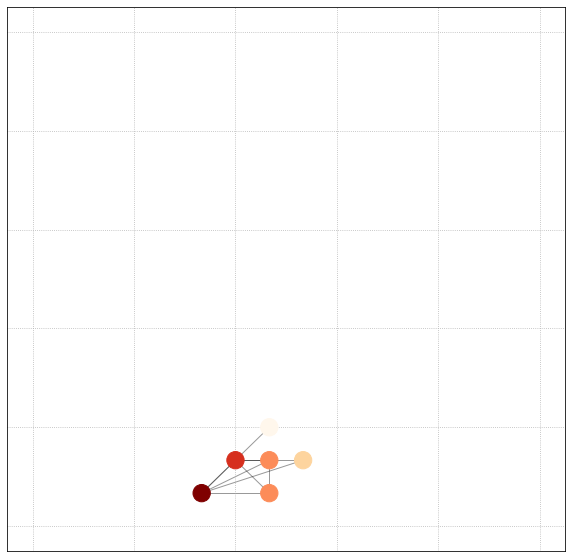

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

p = nx.degree_centrality(G)

nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax, cmap='viridis')
nx.draw_networkx_nodes(
    G,
    pos,
    #node_size=([G.nodes[v]['degree_centrality'] for v in G]*10),
    node_size = 300,
    node_color=list(p.values()),
    #edgecolors=
    cmap=plt.cm.OrRd,
    #cmap='viridis',

    ax=ax
)


ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
#ax.set_xticks(columnlist)
ax.grid(ls=':')
#plt.axis("off")
#ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
'''
layer1 = mpatches.Patch(color='#F28749', label='layer 1')
layer23 = mpatches.Patch(color='#B5D932', label='layer 2/3')
layer4 = mpatches.Patch(color='#8C3A67', label='layer 4')
layer56 = mpatches.Patch(color='#3F93A6', label='layer 5/6')
wm = mpatches.Patch(color='#C9F2EE', label='whitematter')
plt.legend(handles=[layer1, layer23, layer4, layer56, wm])
'''

plt.show()

#fig.savefig('pseudo_anatomy_burst_graph_directions'+filebase+'_.png', dpi = 300, transparent=True)
fig.savefig('cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_burst_connections_dic_graph.png', dpi=300, bbox_inches='tight')


In [67]:
f



NameError: name 'f' is not defined

In [72]:
p = nx.degree_centrality(G)

In [81]:
p = nx.average_node_connectivity(G)

In [292]:
simple_burst_connection

{'R12': [],
 'R4': [],
 'F11': ['D12',
  'D9',
  'E15',
  'E11',
  'D11',
  'C11',
  'D10',
  'F12',
  'R5',
  'D13',
  'F15',
  'E14',
  'E12',
  'E13',
  'D14',
  'F13',
  'F9',
  'G13',
  'E10',
  'E9',
  'E16',
  'D4',
  'C10',
  'F14'],
 'D12': ['D9',
  'E15',
  'D11',
  'C11',
  'D10',
  'F12',
  'D13',
  'F15',
  'E14',
  'E13',
  'D14',
  'F9',
  'G13',
  'E10',
  'E9',
  'F14'],
 'D5': [],
 'C12': [],
 'K11': [],
 'N9': [],
 'R9': [],
 'F2': [],
 'P15': [],
 'A9': [],
 'D9': ['D12',
  'E15',
  'D11',
  'C11',
  'D10',
  'F12',
  'R5',
  'D13',
  'F15',
  'E14',
  'E13',
  'D14',
  'F9',
  'E10',
  'E9',
  'C10',
  'F14'],
 'F16': [],
 'E15': ['F11',
  'D12',
  'D9',
  'E11',
  'D11',
  'C11',
  'D10',
  'F12',
  'R5',
  'D13',
  'F15',
  'E14',
  'E13',
  'D14',
  'F9',
  'G13',
  'E10',
  'E9',
  'E16',
  'D4',
  'C10',
  'F14'],
 'B4': [],
 'E11': ['F11',
  'D12',
  'D9',
  'E15',
  'D11',
  'C11',
  'D10',
  'F12',
  'R5',
  'D13',
  'F15',
  'E14',
  'E12',
  'E13',
  'D14

In [43]:
node_connectivity = nx.all_pairs_node_connectivity(G)

In [42]:
filebase

'cortex_div4_hCSF_ID039_nodrug_spont_1'

In [81]:
G = nx.random_geometric_graph(200, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, "pos")

In [82]:
# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

In [83]:
ncenter

159

In [84]:
G.nodes[86]

{'pos': [0.3846258951047439, 0.540817700478349]}

In [85]:
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']

In [41]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]
    x1, y1 = G.nodes[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

ValueError: too many values to unpack (expected 2)

In [87]:
G.nodes[0]

{'pos': [0.6469180907934919, 0.6190852547475001]}

In [38]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(burst_conn_graph.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

NameError: name 'node_trace' is not defined

In [24]:
G.number_of_nodes()

2

In [23]:
G.add_edge(1,2)

In [49]:
import plotly.graph_objects as go

import networkx as nx

G = nx.random_geometric_graph(200, 0.125)

In [50]:
G

In [53]:
G.nodes()[edges[0]]['pos']

NameError: name 'edges' is not defined